In [163]:
%matplotlib inline
# отключим предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math

from scipy.stats import zscore

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, precision_recall_fscore_support, plot_roc_curve, roc_curve
from sklearn.preprocessing import PolynomialFeatures, normalize, StandardScaler, MinMaxScaler



In [10]:
data = pd.read_csv('credit_scoring_sample.csv', sep =';')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45063 entries, 0 to 45062
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      45063 non-null  int64  
 1   age                                   45063 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  45063 non-null  int64  
 3   DebtRatio                             45063 non-null  float64
 4   NumberOfTimes90DaysLate               45063 non-null  int64  
 5   NumberOfTime60-89DaysPastDueNotWorse  45063 non-null  int64  
 6   MonthlyIncome                         36420 non-null  float64
 7   NumberOfDependents                    43946 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 2.8 MB


In [12]:
data.dropna(inplace = True)

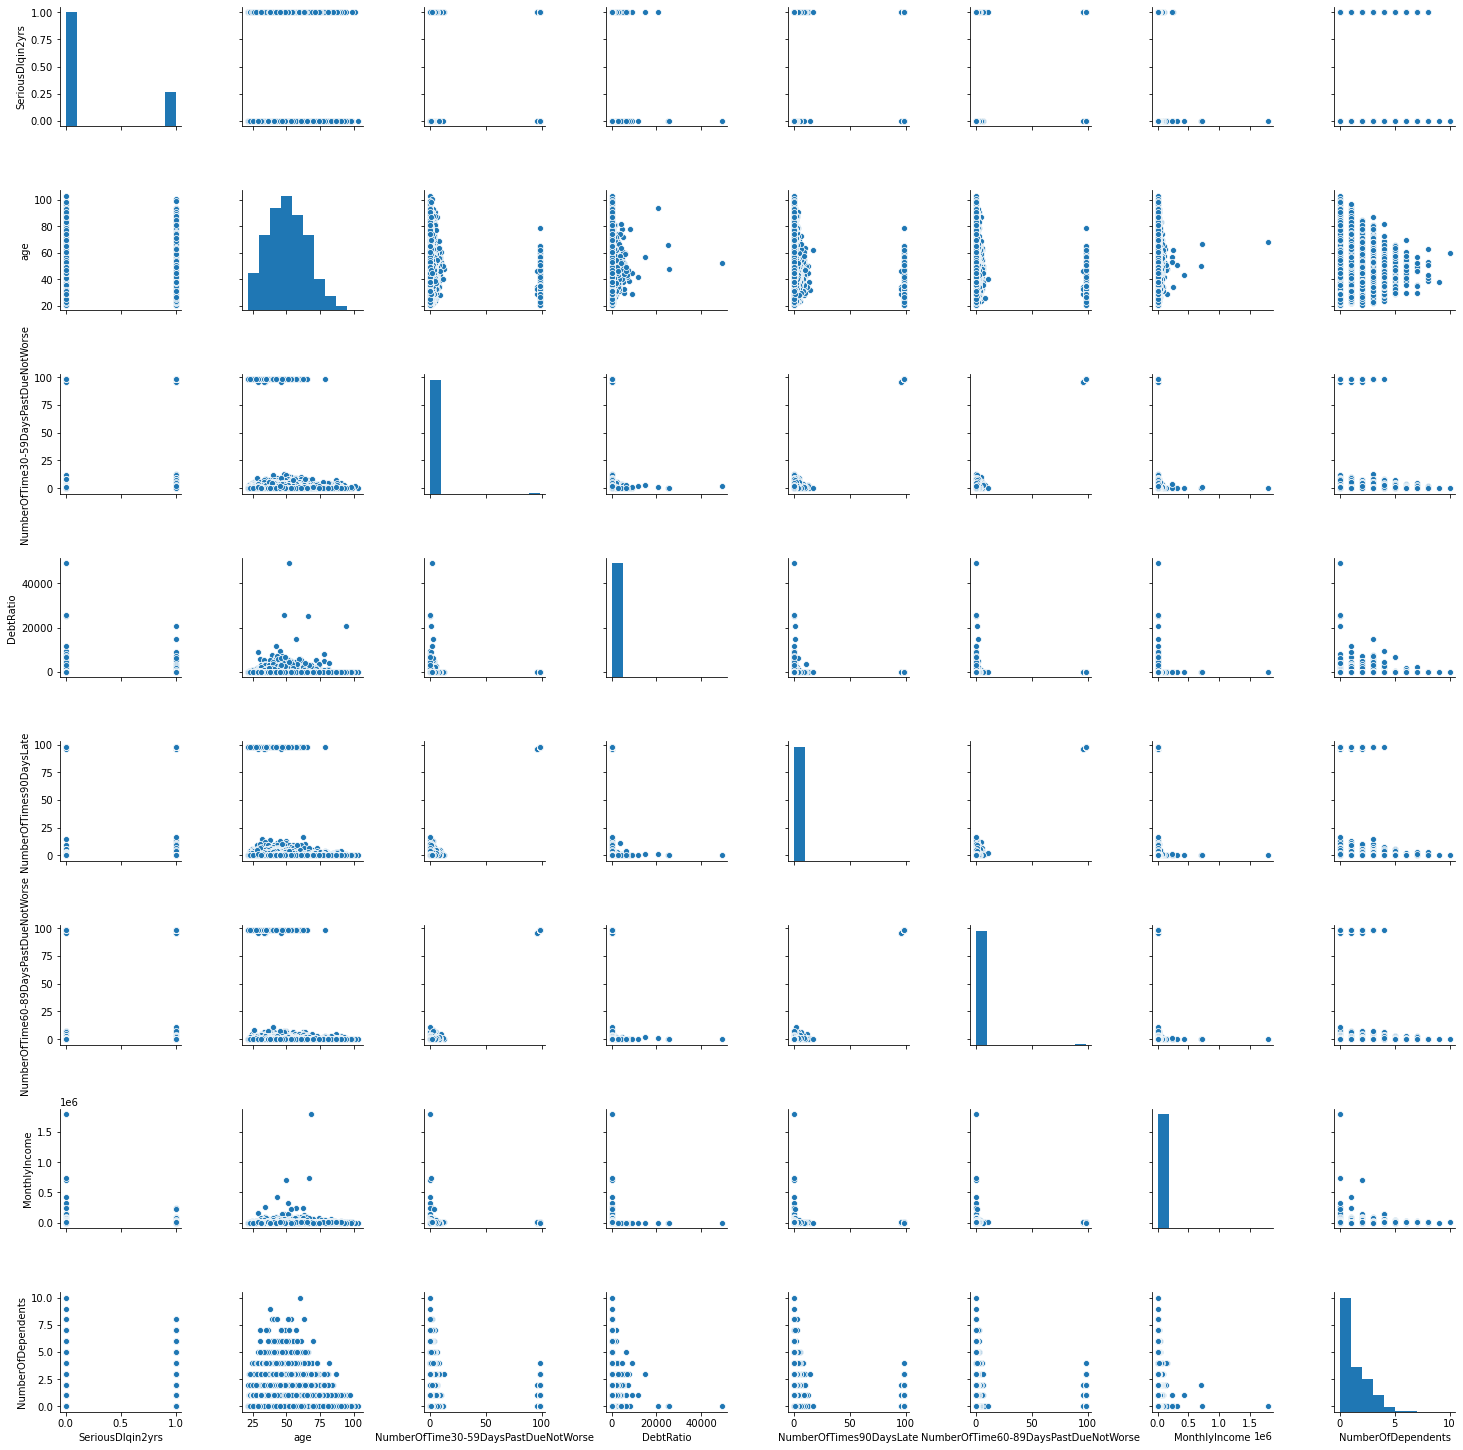

In [5]:
sns.pairplot(data)

Як видно, за вибросів, масштаб більшість показніків знаходяться в одній згруповані області.
Розглянемо кореляції та аутлаєри:

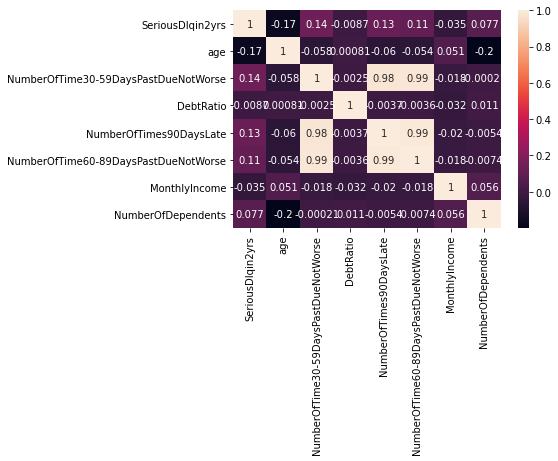

In [13]:
sns.heatmap(data.corr(), annot = True)

Видно велику кореляцію між NumberOfTime30-59DaysPastDueNotWorse, NumberOfTimes90DaysLate та NumberOfTime60-89DaysPastDueNotWorse.
Із цих трьох показників залишимо NumberOfTime30-59DaysPastDueNotWorse, оскільки має найбільшу кореляцію із цільовою фічею

In [14]:
data.drop(['NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse'], inplace = True, axis = 1)

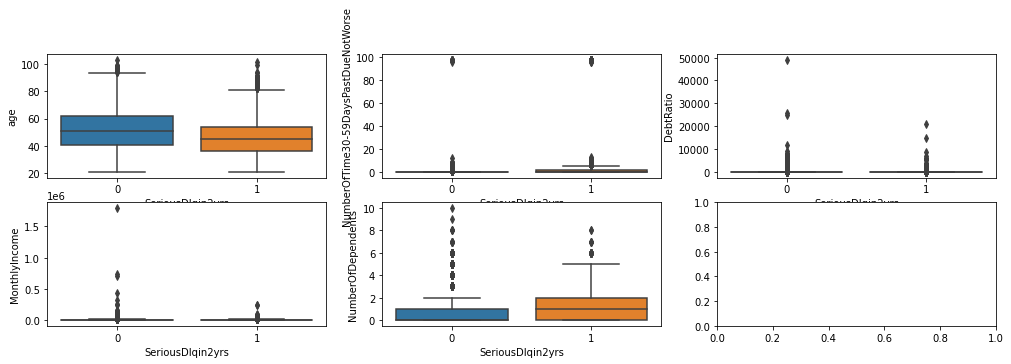

In [15]:
fig, axs = plt.subplots(math.ceil(len(data.drop('SeriousDlqin2yrs', axis = 1).columns) / 3), 3, figsize = (17, 5))

i = 0
for col in data.drop('SeriousDlqin2yrs', axis = 1).columns:
    sns.boxplot(x = data['SeriousDlqin2yrs'], y = data[col], ax = axs[np.unravel_index(i, shape = axs.shape)])
    i += 1

 Як бачимо, ми маємо дуже багато аутлеєрів. Далі проведем чистку від них та знову відобразимо графіки для порівняння.

# Чистка даних

In [88]:
z = np.abs(zscore(data))
data_o = data[(z < 3).all(axis = 1)]
print(f'Original data: {data.shape}')
print(f'New data: {data_o.shape}')

Original data: (36420, 6)
New data: (35678, 6)


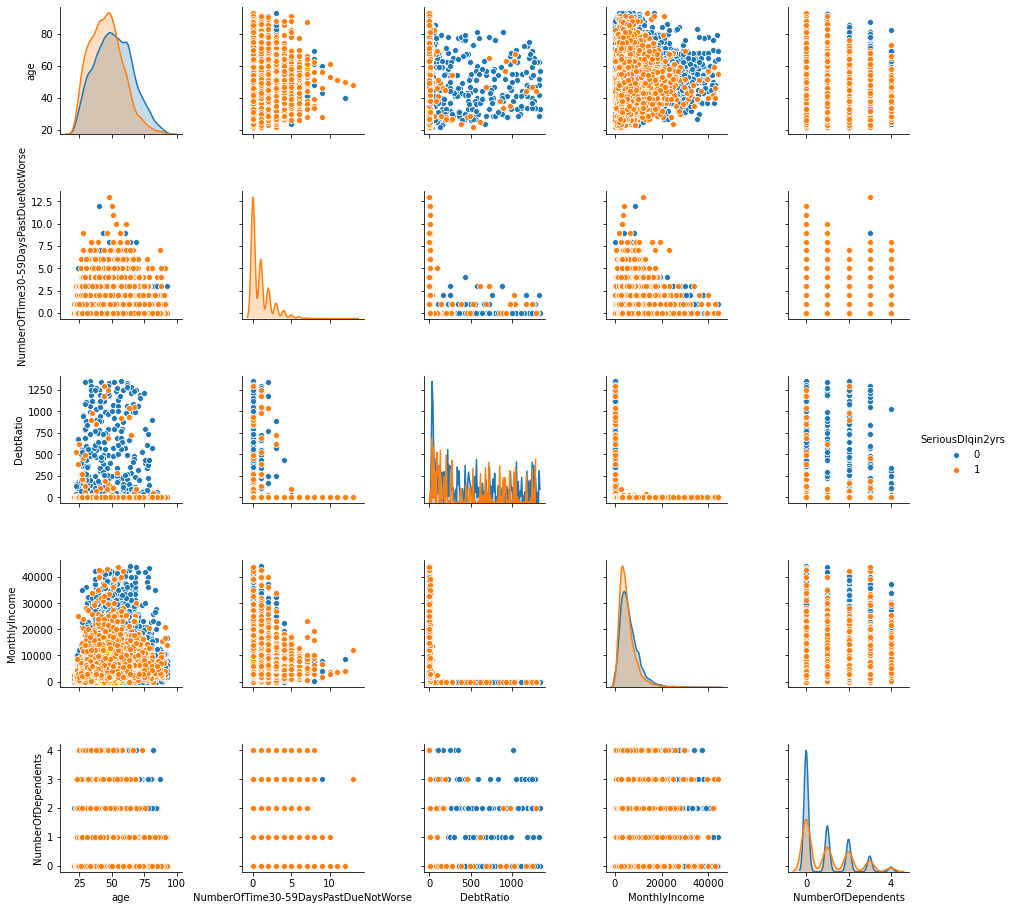

In [100]:
sns.pairplot(data_o, hue = 'SeriousDlqin2yrs')

Як видно, по деяким показникам присутні суттєві різниці за показником SeriousDlqin2yrs

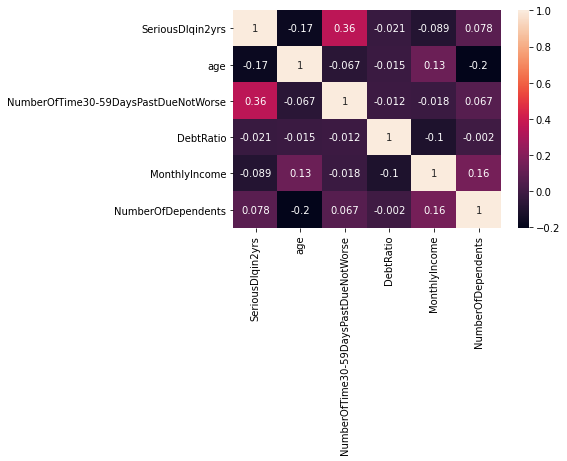

In [128]:
sns.heatmap(data_o.corr(), annot = True)

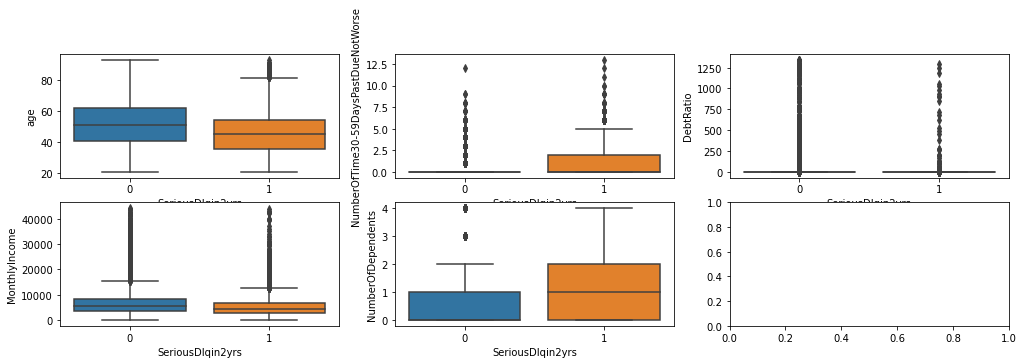

In [164]:
fig, axs = plt.subplots(math.ceil(len(data_o.drop('SeriousDlqin2yrs', axis = 1).columns) / 3), 3, figsize = (17, 5))

i = 0
for col in data_o.drop('SeriousDlqin2yrs', axis = 1).columns:
    sns.boxplot(x = data_o['SeriousDlqin2yrs'], y = data_o[col], ax = axs[np.unravel_index(i, shape = axs.shape)])
    i += 1

# Feature engineering

Оскільки ми бачили цікаві взаємовідображення через pairplot, спрбуємо створити нові фічі для цих показників

In [33]:
# при створені додаткових фіч, показники погіршилися

# data_o['dr/age'] = data_o['DebtRatio'] / data_o['age']
# data_o['mi/age'] = data_o['MonthlyIncome'] / data_o['age']
# # data_o['dr/nt30-50'] = data_o['DebtRatio'] / data_o['NumberOfTime30-59DaysPastDueNotWorse']
# data_o['nt30-50/dr'] = data_o['NumberOfTime30-59DaysPastDueNotWorse'] / data_o['DebtRatio']
# # data_o['dr/nd'] = data_o['DebtRatio'] / data_o['NumberOfDependents']
# data_o['nd/dr'] = data_o['NumberOfDependents'] / data_o['DebtRatio']
# # data_o['mi/nd'] = data_o['MonthlyIncome'] / data_o['NumberOfDependents']
# data_o['nd/mi'] = data_o['NumberOfDependents'] / data_o['MonthlyIncome']
# # data_o['age/nd'] = data_o['age'] / data_o['NumberOfDependents']
# data_o['nd/age'] = data_o['NumberOfDependents'] / data_o['age']
# data_o.dropna(inplace = True)
# data_o[data_o == np.inf] = 1

In [124]:
X = data.drop('SeriousDlqin2yrs', axis = 1)
y = data['SeriousDlqin2yrs']

X_o = data_o.drop('SeriousDlqin2yrs', axis = 1)
y_o = data_o['SeriousDlqin2yrs']

In [85]:
# генеруємо поліноміальні фічі (результат погіршився)
# X_o = PolynomialFeatures().fit_transform(X_o)

In [121]:
# масштабування
# X_o = normalize(X_o, axis = 0) # результат погіршився
# X_o = StandardScaler().fit_transform(X_o) #точність для логістичної регресії збільшилася на 1 десятитисячну
# X_o = MinMaxScaler().fit_transform(X_o) #точність для логістичної регресії збільшилася на 1 десятитисячну

# Models

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X_o, y_o, train_size = 0.8, random_state = 1)

### LogisticRegression

In [19]:
lr = LogisticRegression()
parameters = {
    'C': (0.0001, 0.001, 0.01, 0.1, 1, 10),
    'class_weight': ('balanced', 'None')
}

lr_grid = GridSearchCV(lr, parameters, verbose = True, scoring = 'roc_auc')
lr_grid.fit(X_o, y_o)
lr_grid.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   19.9s finished


0.7477474230029574

In [143]:
lr_best = LogisticRegression(C = 10)
lr_best.fit(X_train, y_train)

LogisticRegression(C=10)

### RandomForestClassifier

In [171]:
rf = RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           random_state = 1,
                           oob_score = True)
parameters = {
    'class_weight': ('balanced', None),
    'max_features': [1, 2, 4], 
    'min_samples_leaf': [3, 5, 7, 9], 
    'max_depth': [5,10,15]
}

rf_grid = GridSearchCV(rf, parameters, verbose = True, scoring = 'roc_auc')
rf_grid.fit(X_o, y_o)
rf_grid.best_score_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 12.1min finished


0.7695219396418962

In [172]:
rf_grid.best_params_

{'class_weight': None,
 'max_depth': 10,
 'max_features': 2,
 'min_samples_leaf': 9}

In [126]:
rf_best = RandomForestClassifier(n_estimators = 100,
                                n_jobs = -1,
                                random_state = 1,
                                oob_score = True,
                                max_depth = 10,
                                max_features = 2,
                                min_samples_leaf = 9)
rf_best.fit(X_train, y_train)
# cross_val_score(rf_best, X_o, y_o).mean()

roc_auc_score(y_test, rf_best.predict(X_test))

0.628382480449466

### Visualization

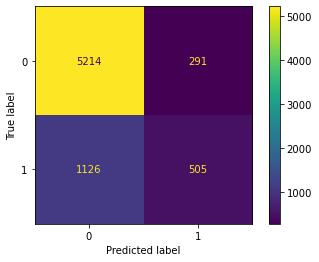

In [133]:
plot_confusion_matrix(rf_best, X_test, y_test)

In [169]:
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, rf_best.predict(X_test), average = 'binary')
print('Random forest scores:')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Fscore: {fscore}')

Random forest scores:
Precision: 0.6344221105527639
Recall: 0.3096259963212753
Fscore: 0.4161516275236918


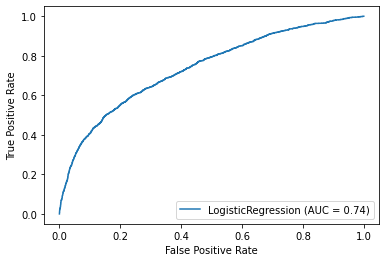

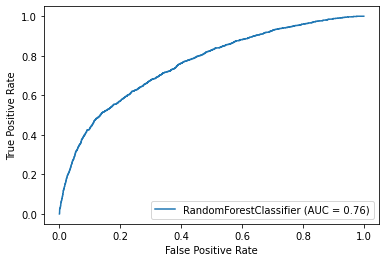

In [168]:
plot_roc_curve(lr_best, X_test, y_test, name = 'LogisticRegression')
plot_roc_curve(rf_best, X_test, y_test, name = 'RandomForestClassifier')